# Imports

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from IPython.display import Image
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from functools import reduce # reduzir uma função para aplicar
import pickle
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

## Helper Functions

In [2]:
def show_null(df):
    null_columns = (df.isnull().sum(axis=0)/len(df)).sort_values(ascending=False).index
    null_data = pd.concat( [df.isnull().sum(axis=0),
                            (df.isnull().sum(axis=0)/len(df)).sort_values(ascending=False), 
                            df.loc[:, df.columns.isin(list(null_columns))].dtypes], axis=1 )

    null_data.columns = ['#', '%null', 'type']
    null_data = null_data.sort_values(ascending=False, by='%null')

    return null_data

In [3]:
def plot_num(df, feature):
    fig = plt.figure(figsize=(12,8))
    gs = GridSpec(1,2)
    sns.boxplot(y=feature, data=df, color='firebrick', ax=fig.add_subplot(gs[0,0]))
    plt.ylabel(feature)
    sns.stripplot(y=df[feature], color='darkcyan', ax=fig.add_subplot(gs[0,1]))
    plt.ylabel(None)
    plt.show()

In [4]:
def plot_cat(df, feature):
    fig = plt.figure(figsize=(12,8))
    ax = sns.countplot(data=df, x=feature)
    for p in ax.patches:
        ax.annotate(f'\n{p.get_height()}', 
                        (p.get_x()+0.4, p.get_height()+5), 
                        ha='center', 
                        color='black')

    plt.xlabel('\n' + feature)
    plt.ylabel('Quantidade de Clientes')
    plt.show()

## Load Data

In [5]:
df = pd.read_csv("data/marketing_campaign.csv", delimiter='\t') # csv with tabs delimiter

## EDA

## People

ID: Customer's unique identifier

Year_Birth: Customer's birth year

Education: Customer's education level

Marital_Status: Customer's marital status

Income: Customer's yearly household income

Kidhome: Number of children in customer's household

Teenhome: Number of teenagers in customer's household

Dt_Customer: Date of customer's enrollment with the company

Recency: Number of days since customer's last purchase

Complain: 1 if the customer complained in the last 2 years, 0 otherwise

In [7]:
people = df[['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'Complain']]
people.Dt_Customer = pd.to_datetime(people.Dt_Customer, dayfirst=True)

In [8]:
people.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,Complain
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,0
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,0


In [9]:
show_null(people)

,#,%null,type
Income,24,0.010714,float64
ID,0,0.000000,int64
Year_Birth,0,0.000000,int64
Education,0,0.000000,object
Marital_Status,0,0.000000,object
Kidhome,0,0.000000,int64
Teenhome,0,0.000000,int64
Dt_Customer,0,0.000000,datetime64[ns]
Recency,0,0.000000,int64
Complain,0,0.000000,int64


#### Income

In [10]:
people.dropna(inplace=True)

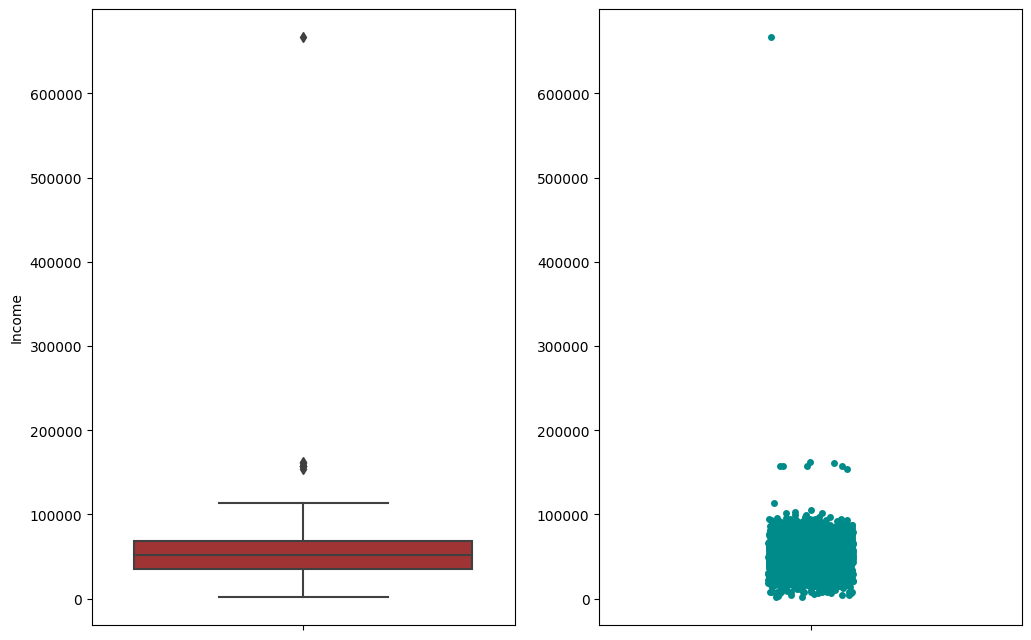

In [11]:
plot_num(people, 'Income')

In [12]:
people = people[people.Income < 200000]

#### Year Birth

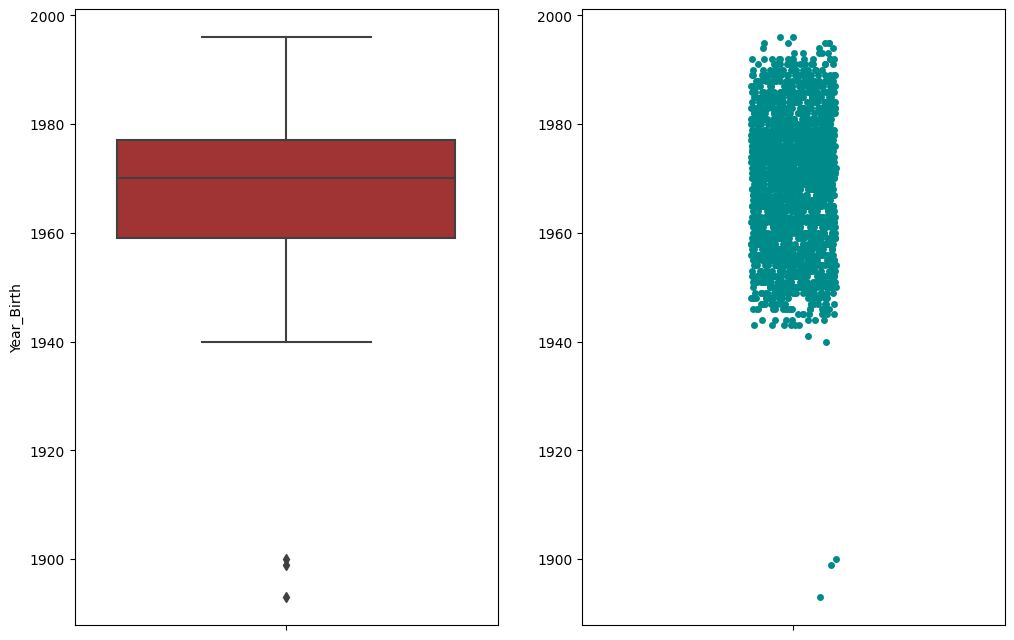

In [13]:
plot_num(people, 'Year_Birth')

In [14]:
people = people[people.Year_Birth > 1930]

#### Education

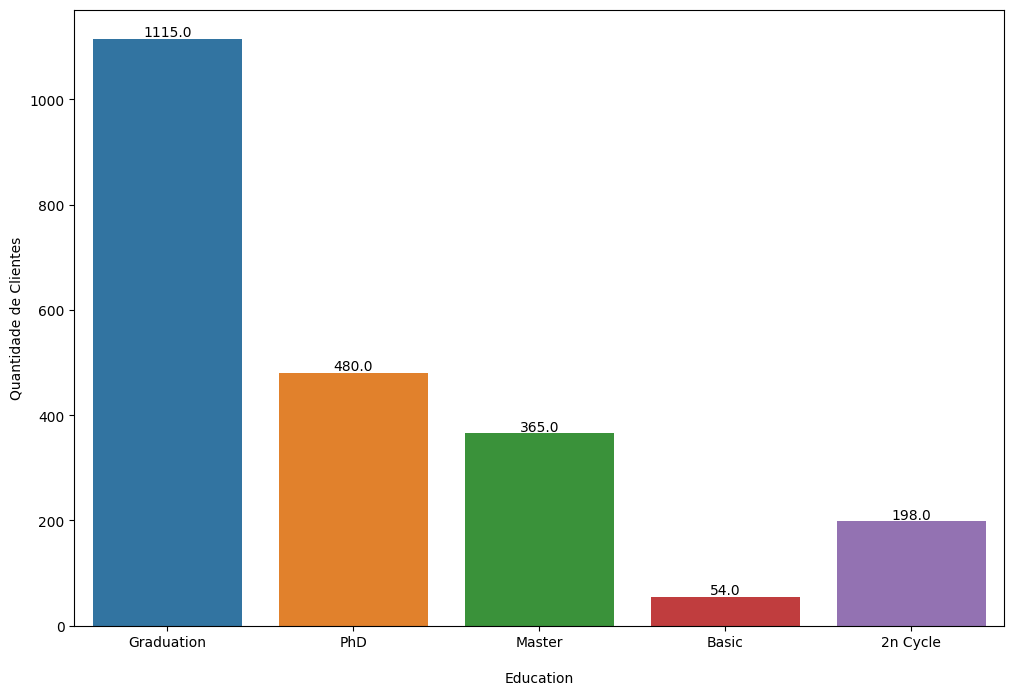

In [15]:
plot_cat(people, 'Education')

In [16]:
people.Education = people.Education.apply(lambda x: 0 if x == 'Basic' else
                                          1 if x == '2n Cycle' else
                                          2 if x == 'Graduation' else
                                          3 if x == 'Master' else
                                          4 if x == 'PhD' else 0)

#### Marital_Status

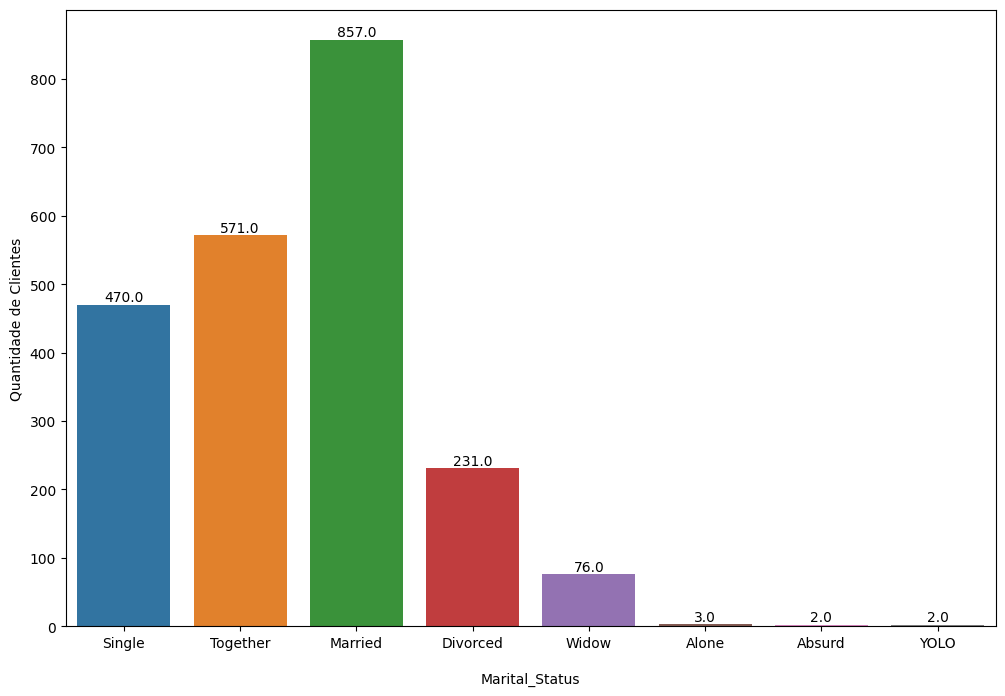

In [17]:
plot_cat(people, 'Marital_Status')

In [18]:
people = people[people.Marital_Status != 'Absurd']

In [19]:
people.Marital_Status = people.Marital_Status.apply(lambda x: 'Single' if x=='Alone' else
                                                              'Single' if x=='YOLO' else x)

In [20]:
people.Marital_Status = people.Marital_Status.apply(lambda x: 'Together' if x=='Married' else x ) 

In [21]:
people = pd.get_dummies(people) #, drop_first=True

#### Kidhome

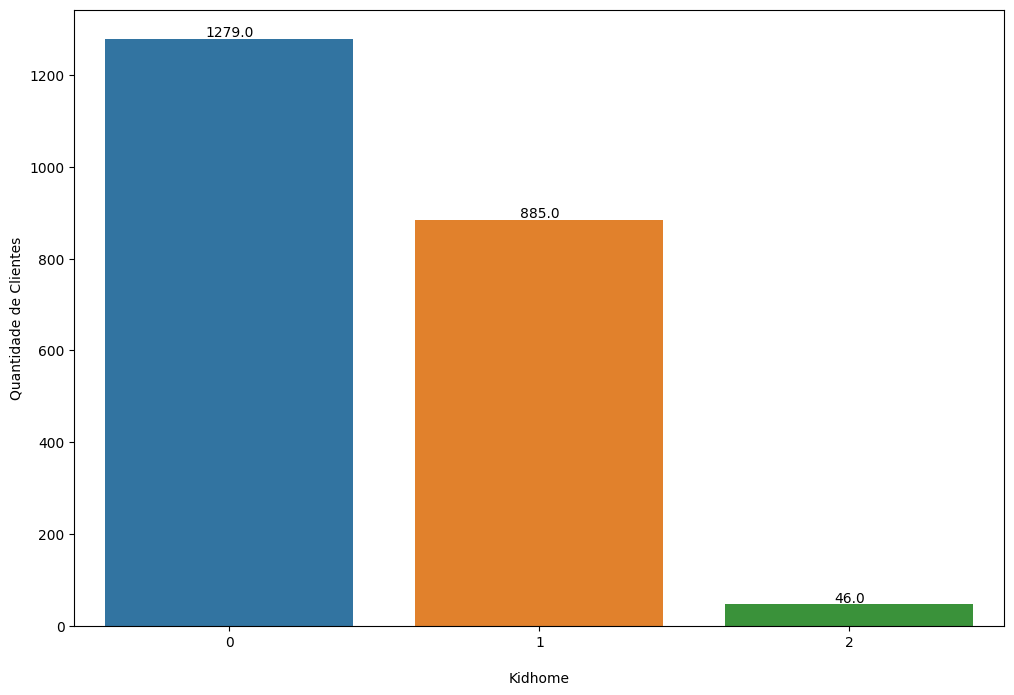

In [22]:
plot_cat(people, 'Kidhome')

#### Teen Home

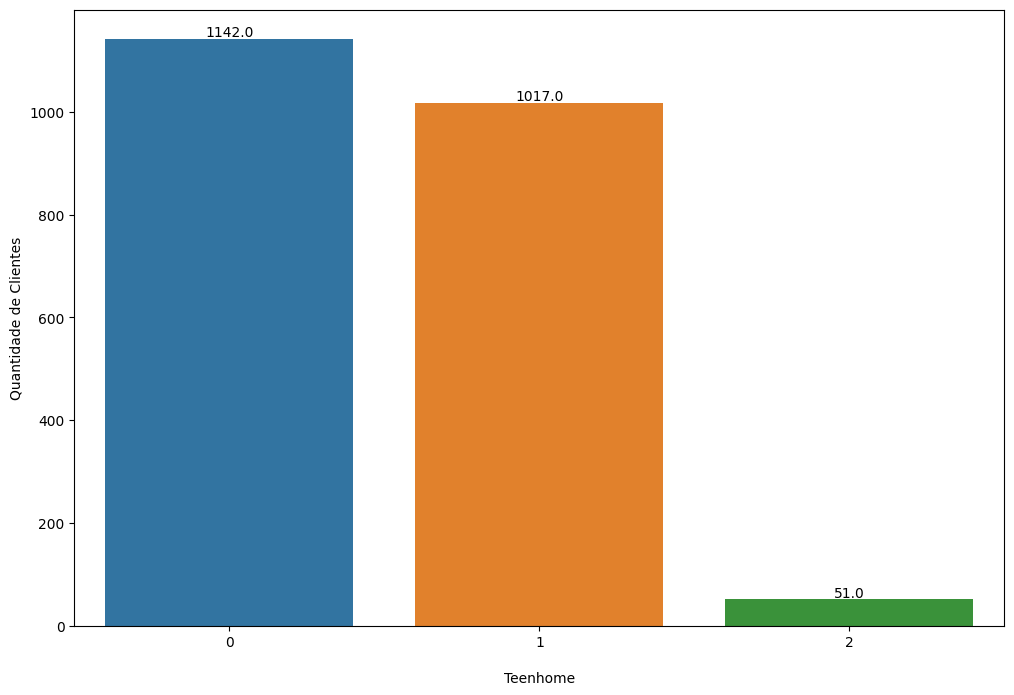

In [23]:
plot_cat(people, 'Teenhome')

#### ChildrenHome

In [24]:
people['ChildrenHome'] = people.Teenhome + people.Kidhome

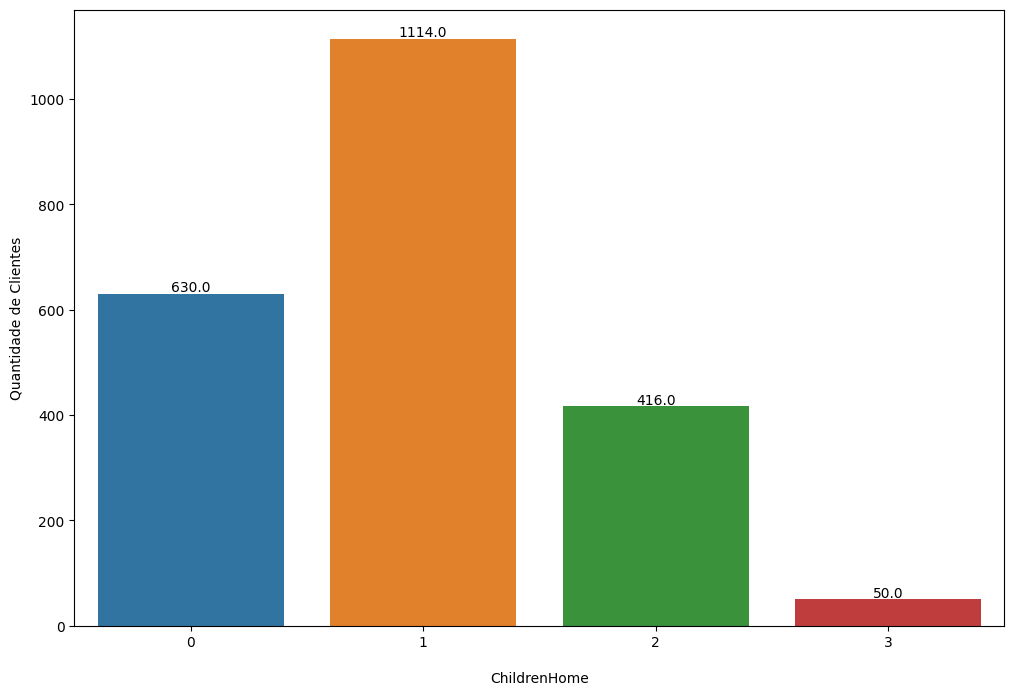

In [25]:
plot_cat(people, 'ChildrenHome')

In [26]:
people.drop(columns=['Kidhome', 'Teenhome'], inplace=True)

#### Dt_Customer

In [27]:
people.Dt_Customer.min()

Timestamp('2012-07-30 00:00:00')

In [28]:
people.Dt_Customer.max()

Timestamp('2014-06-29 00:00:00')

In [29]:
(people['Dt_Customer'] + pd.to_timedelta(people['Recency'], unit='d')).max()

Timestamp('2014-10-04 00:00:00')

In [30]:
people['LifeTime'] =  (pd.to_datetime('2014-10-05') - people['Dt_Customer']).dt.days/30 
# data da coleta dos dados - data que o cliente entrou na plataforma = quantidade de dias da plataforma ( divide por 30 quantidade de meses )

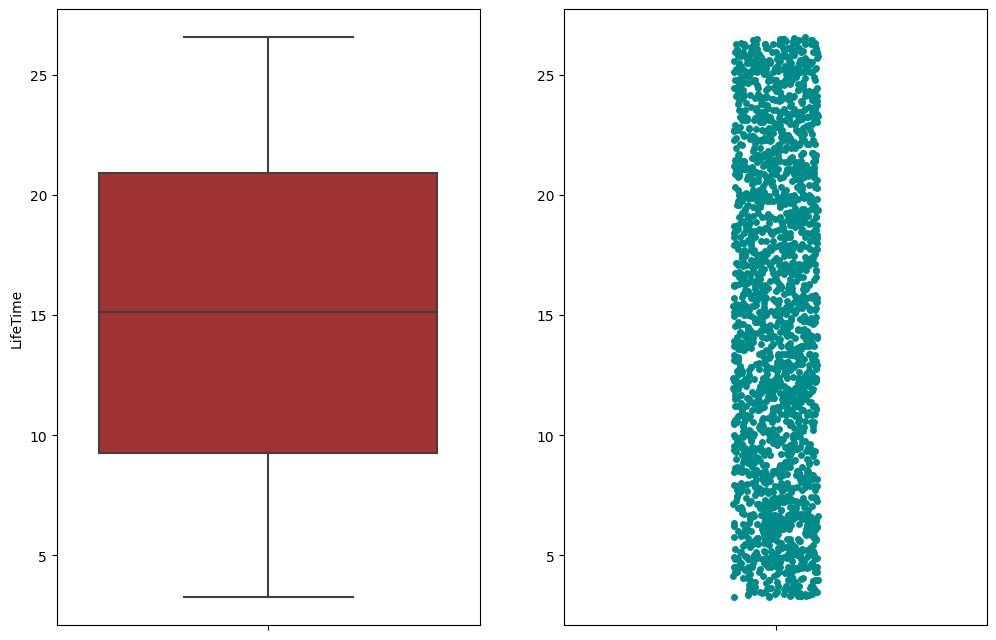

In [31]:
plot_num(people, 'LifeTime')

#### Recency

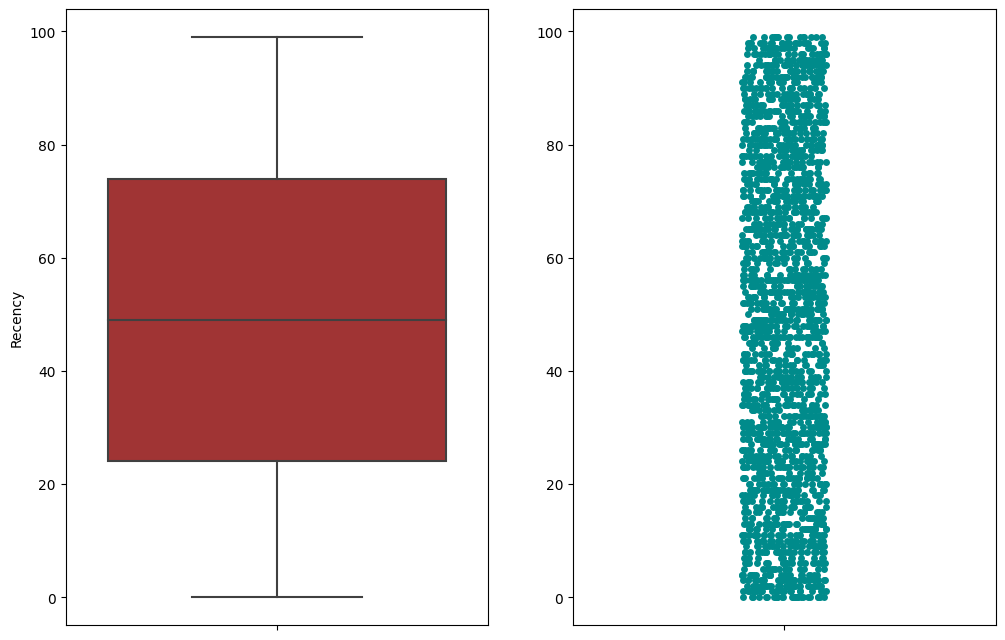

In [32]:
plot_num(people, 'Recency')

#### Complain

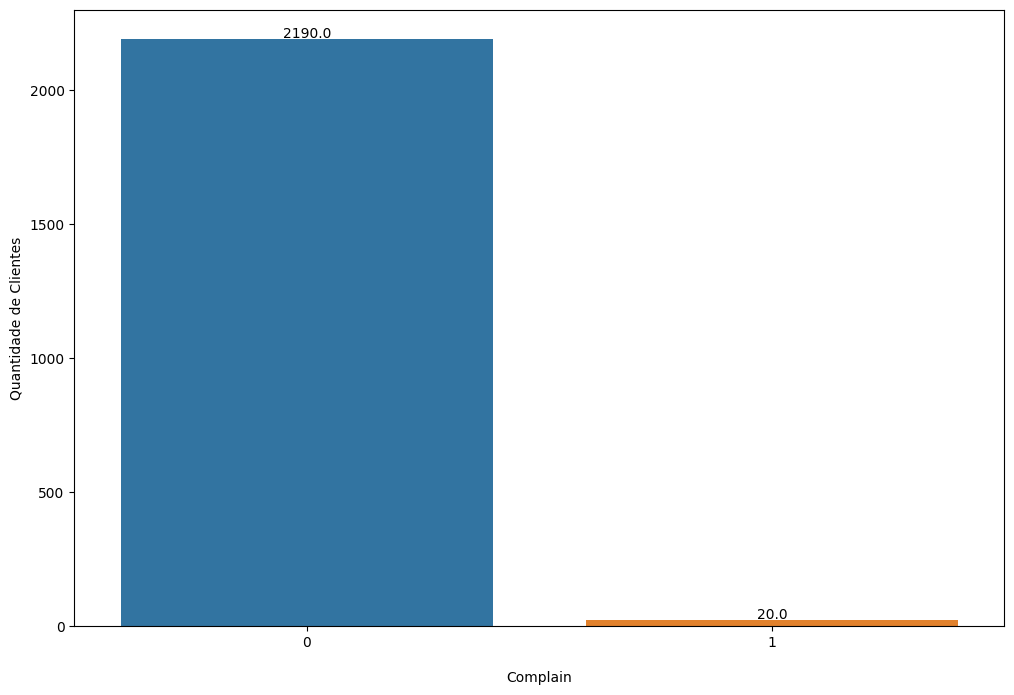

In [33]:
plot_cat(people, 'Complain')

In [34]:
people.drop(columns=['Complain', 'Dt_Customer'], inplace=True )

## Products


MntWines: Amount spent on wine in last 2 years

MntFruits: Amount spent on fruits in last 2 years

MntMeatProducts: Amount spent on meat in last 2 years

MntFishProducts: Amount spent on fish in last 2 years

MntSweetProducts: Amount spent on sweets in last 2 years

MntGoldProds: Amount spent on gold in last 2 years




In [35]:
products = df[['ID', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']]

In [36]:
products.head()

,ID,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds
0,5524,635,88,546,172,88,88
1,2174,11,1,6,2,1,6
2,4141,426,49,127,111,21,42
3,6182,11,4,20,10,3,5
4,5324,173,43,118,46,27,15


In [37]:
show_null(products)

,#,%null,type
ID,0,0.0,int64
MntWines,0,0.0,int64
MntFruits,0,0.0,int64
MntMeatProducts,0,0.0,int64
MntFishProducts,0,0.0,int64
MntSweetProducts,0,0.0,int64
MntGoldProds,0,0.0,int64


#### MntWines

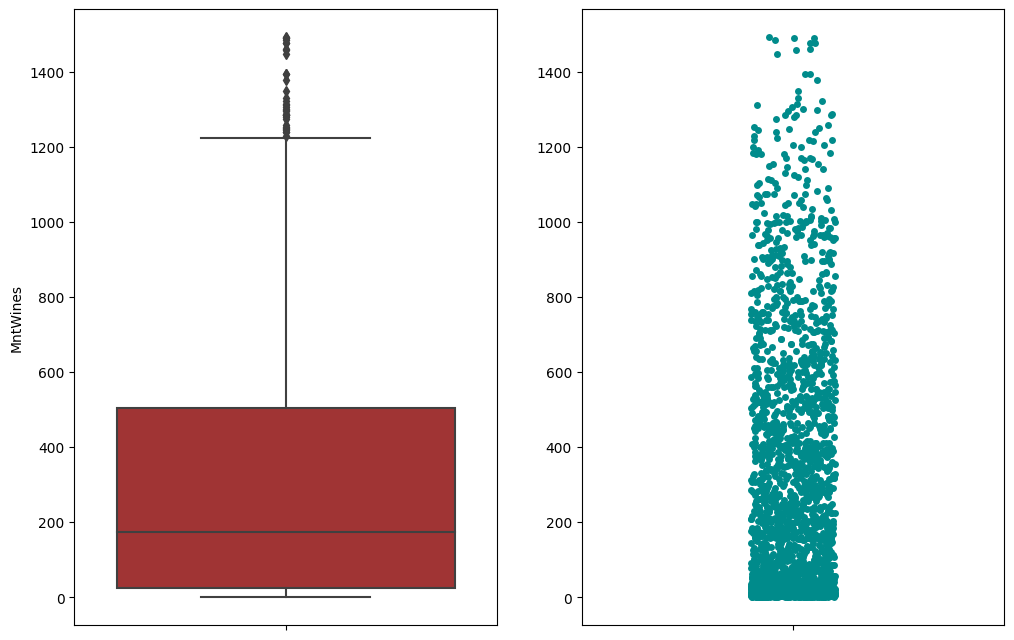

In [38]:
plot_num(products, 'MntWines')

#### MntFruits

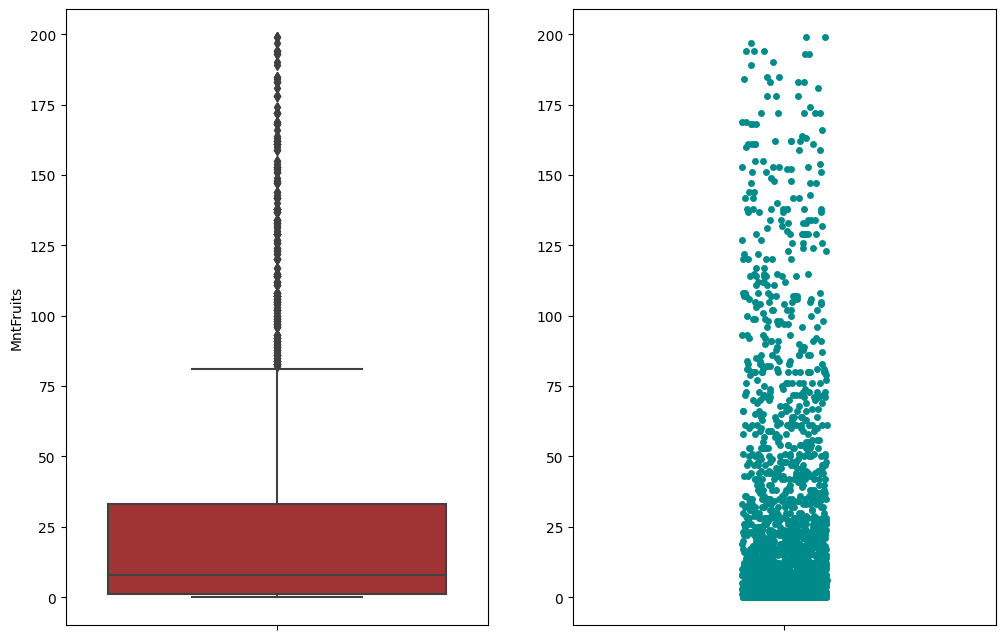

In [39]:
plot_num(products, 'MntFruits')

#### MntMeatProducts

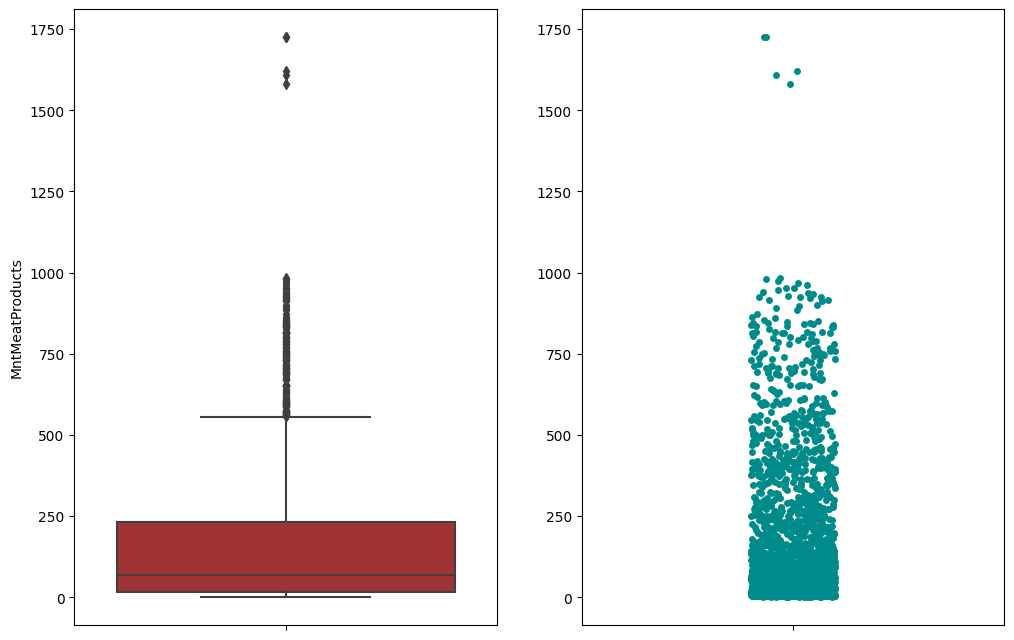

In [40]:
plot_num(products, 'MntMeatProducts')

#### MntFishProducts

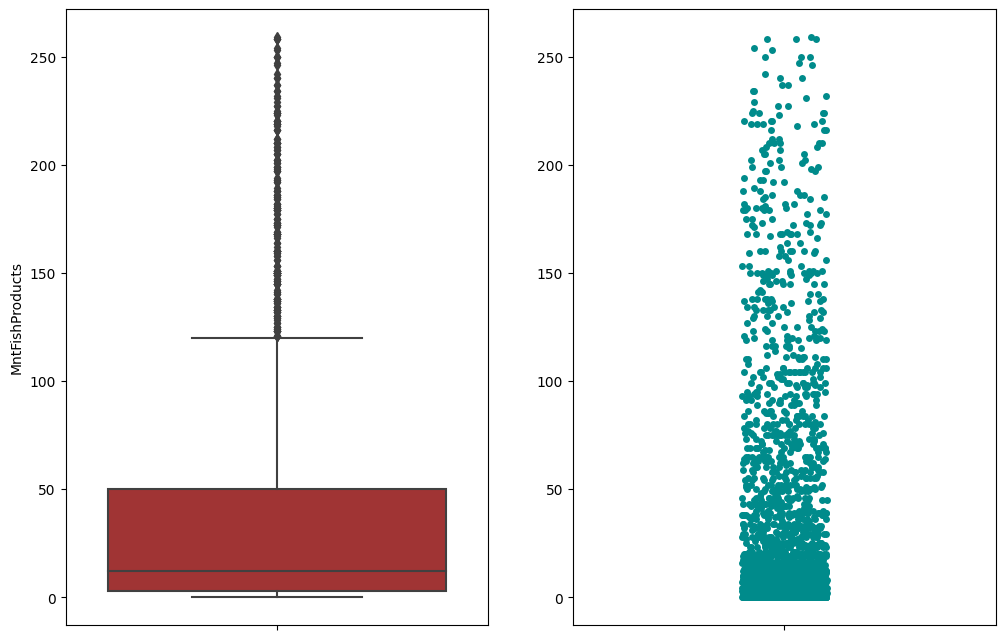

In [41]:
plot_num(products, 'MntFishProducts')

#### MntSweetProducts

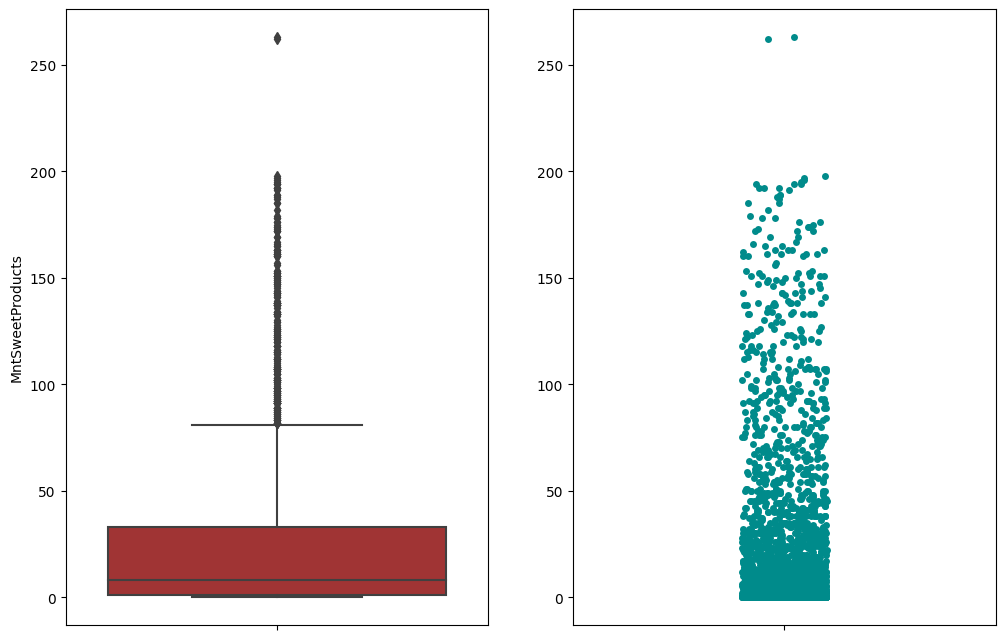

In [42]:
plot_num(products, 'MntSweetProducts')

#### MntGoldProds

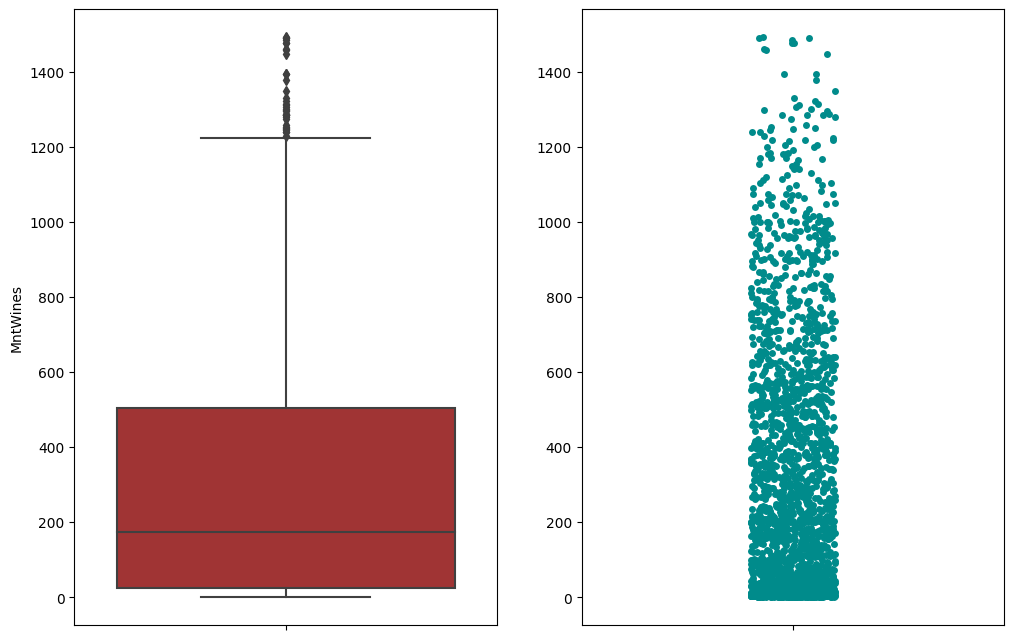

In [43]:
plot_num(products, 'MntWines')

#### TotalAmountSpent

In [44]:
products['TotalAmountSpent'] = products.MntWines + products.MntFruits + products.MntMeatProducts + products.MntFishProducts \
                            + products.MntSweetProducts+ products.MntGoldProds

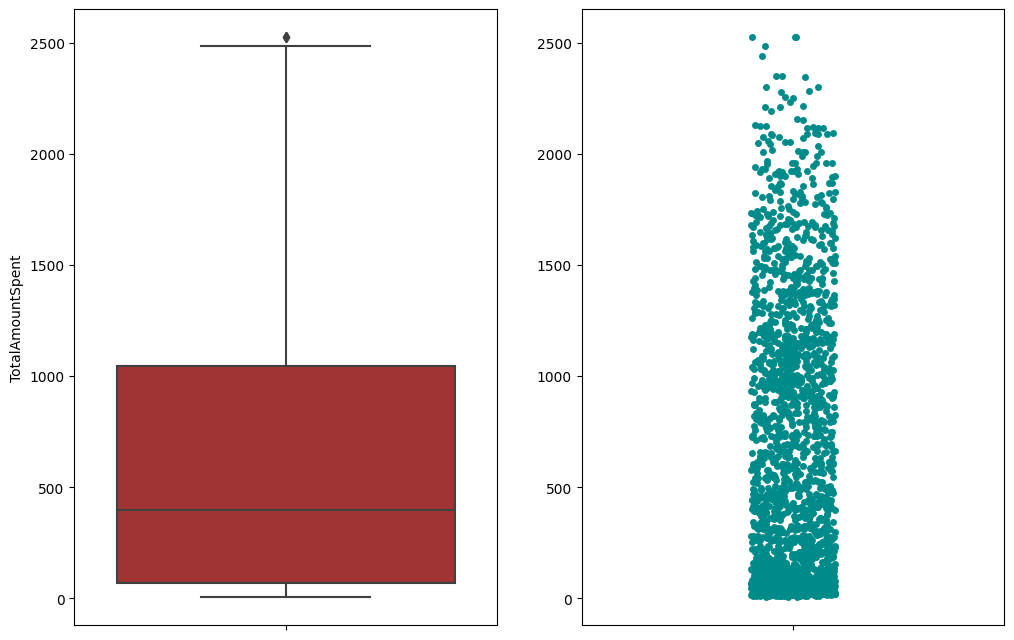

In [45]:
plot_num(products, 'TotalAmountSpent')

#### Percentual Products

In [46]:
products.MntWines = products.MntWines / products['TotalAmountSpent']
products.MntFruits = products.MntFruits / products['TotalAmountSpent']
products.MntMeatProducts = products.MntMeatProducts / products['TotalAmountSpent']
products.MntFishProducts = products.MntFishProducts / products['TotalAmountSpent']
products.MntSweetProducts = products.MntSweetProducts / products['TotalAmountSpent']
products.MntGoldProds = products.MntGoldProds / products['TotalAmountSpent']

In [47]:
products.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,2240.0,5592.159821,3246.662198,0.0,2828.250000,5458.500000,8427.750000,11191.000000
MntWines,2240.0,0.458481,0.228411,0.0,0.289506,0.457482,0.639143,0.963303
MntFruits,2240.0,0.049505,0.055867,0.0,0.008924,0.029840,0.070237,0.445545
MntMeatProducts,2240.0,0.249508,0.126633,0.0,0.156250,0.233447,0.328227,0.997110
MntFishProducts,2240.0,0.071532,0.077909,0.0,0.012571,0.048193,0.104703,0.590909
MntSweetProducts,2240.0,0.050777,0.061184,0.0,0.008621,0.033333,0.070411,0.945848
MntGoldProds,2240.0,0.120196,0.108988,0.0,0.038095,0.086294,0.169768,0.894150
TotalAmountSpent,2240.0,605.798214,602.249288,5.0,68.750000,396.000000,1045.500000,2525.000000


## Promotion

AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise

AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise

AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise

AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise

AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise

Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

In [48]:
promotion = df[['ID', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']]

In [49]:
promotion.describe()

,ID,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,5592.159821,0.064286,0.013393,0.072768,0.074554,0.072768,0.149107
std,3246.662198,0.245316,0.114976,0.259813,0.262728,0.259813,0.356274
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2828.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5458.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8427.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,11191.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [50]:
promotion['AcceptedCmp'] = promotion.AcceptedCmp1 + promotion.AcceptedCmp2 + promotion.AcceptedCmp3 \
                         + promotion.AcceptedCmp4 + promotion.AcceptedCmp5 + promotion.Response

In [51]:
promotion['AcceptedCmp'].describe()

count    2240.000000
mean        0.446875
std         0.890543
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         5.000000
Name: AcceptedCmp, dtype: float64

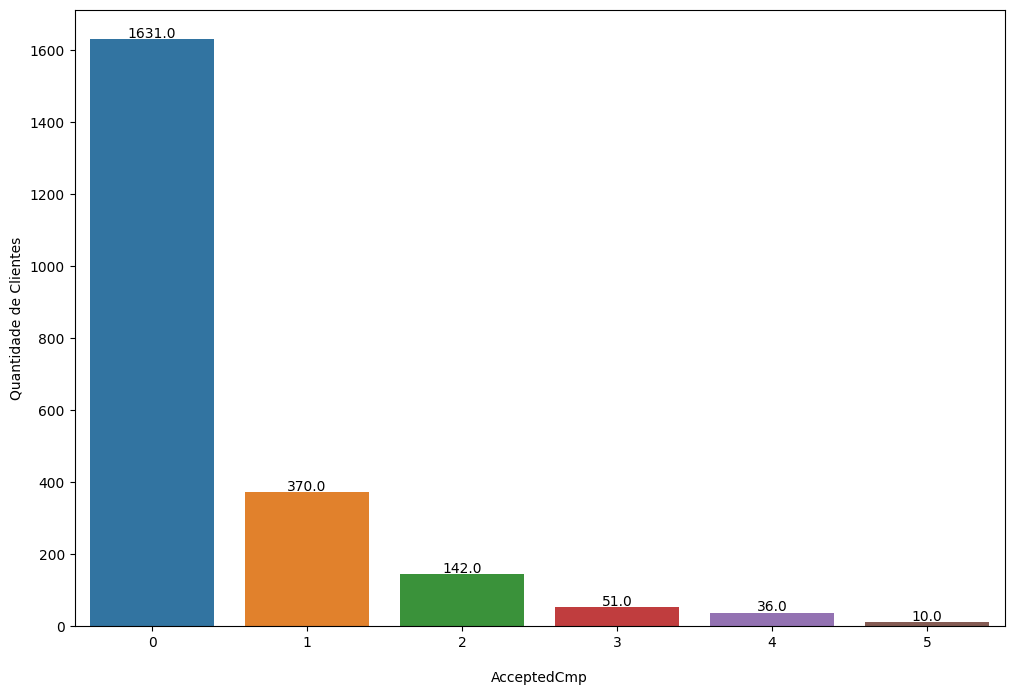

In [52]:
plot_cat(promotion, 'AcceptedCmp')

In [53]:
promotion = promotion[['ID', 'AcceptedCmp']]

## Place


NumWebPurchases: Number of purchases made through the company’s website

NumCatalogPurchases: Number of purchases made using a catalogue

NumDealsPurchases: Number of purchases made with a discount

NumStorePurchases: Number of purchases made directly in stores

NumWebVisitsMonth: Number of visits to company’s website in the last month



In [54]:
place = df[['ID', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases', 'NumWebVisitsMonth']]

In [55]:
show_null(place)

,#,%null,type
ID,0,0.0,int64
NumWebPurchases,0,0.0,int64
NumCatalogPurchases,0,0.0,int64
NumStorePurchases,0,0.0,int64
NumDealsPurchases,0,0.0,int64
NumWebVisitsMonth,0,0.0,int64


In [56]:
place['TotalPurchases'] = place.NumWebPurchases + place.NumCatalogPurchases + place.NumStorePurchases

In [57]:
place.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,2240.0,5592.159821,3246.662198,0.0,2828.25,5458.5,8427.75,11191.0
NumWebPurchases,2240.0,4.084821,2.778714,0.0,2.00,4.0,6.00,27.0
NumCatalogPurchases,2240.0,2.662054,2.923101,0.0,0.00,2.0,4.00,28.0
NumStorePurchases,2240.0,5.790179,3.250958,0.0,3.00,5.0,8.00,13.0
NumDealsPurchases,2240.0,2.325000,1.932238,0.0,1.00,2.0,3.00,15.0
NumWebVisitsMonth,2240.0,5.316518,2.426645,0.0,3.00,6.0,7.00,20.0
TotalPurchases,2240.0,12.537054,7.205741,0.0,6.00,12.0,18.00,32.0


In [58]:
place = place[ place.TotalPurchases > 0]

In [59]:
place.NumWebPurchases = place.NumWebPurchases / place.TotalPurchases
place.NumCatalogPurchases = place.NumCatalogPurchases / place.TotalPurchases
place.NumStorePurchases = place.NumStorePurchases / place.TotalPurchases
place.NumDealsPurchases = place.NumDealsPurchases / place.TotalPurchases

In [60]:
place.describe()

,ID,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,NumWebVisitsMonth,TotalPurchases
count,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000
mean,5585.427037,0.329874,0.164809,0.505317,0.247963,5.300806,12.570725
std,3245.168172,0.121858,0.140668,0.149485,0.356679,2.372957,7.186011
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2817.750000,0.250000,0.000000,0.401852,0.083333,3.000000,6.000000
50%,5453.500000,0.333333,0.150000,0.500000,0.200000,6.000000,12.000000
75%,8419.500000,0.400000,0.250000,0.600000,0.333333,7.000000,18.000000
max,11191.000000,1.000000,1.000000,1.000000,15.000000,20.000000,32.000000


In [61]:
place = place[ place.NumDealsPurchases <= 1]

#### NumWebVisitsMonth

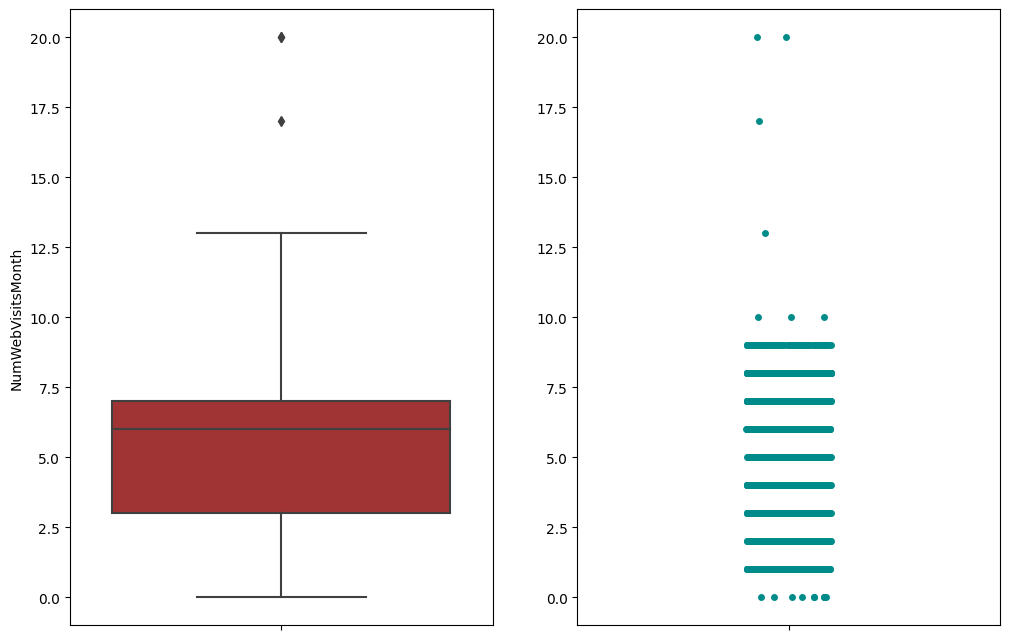

In [62]:
plot_num(place, 'NumWebVisitsMonth')

### Juntando Dados

In [63]:
df_lista = [people, products, promotion, place]

In [64]:
df_final = reduce(lambda df1, df2: pd.merge(df1, df2, on='ID'), df_lista)

In [65]:
df_final.shape

(2203, 25)

In [66]:
df_final.drop(columns='ID', inplace=True)

In [67]:
### Pre processing

In [68]:
df_final.dtypes

Year_Birth                   int64
Education                    int64
Income                     float64
Recency                      int64
Marital_Status_Divorced      uint8
Marital_Status_Single        uint8
Marital_Status_Together      uint8
Marital_Status_Widow         uint8
ChildrenHome                 int64
LifeTime                   float64
MntWines                   float64
MntFruits                  float64
MntMeatProducts            float64
MntFishProducts            float64
MntSweetProducts           float64
MntGoldProds               float64
TotalAmountSpent             int64
AcceptedCmp                  int64
NumWebPurchases            float64
NumCatalogPurchases        float64
NumStorePurchases          float64
NumDealsPurchases          float64
NumWebVisitsMonth            int64
TotalPurchases               int64
dtype: object

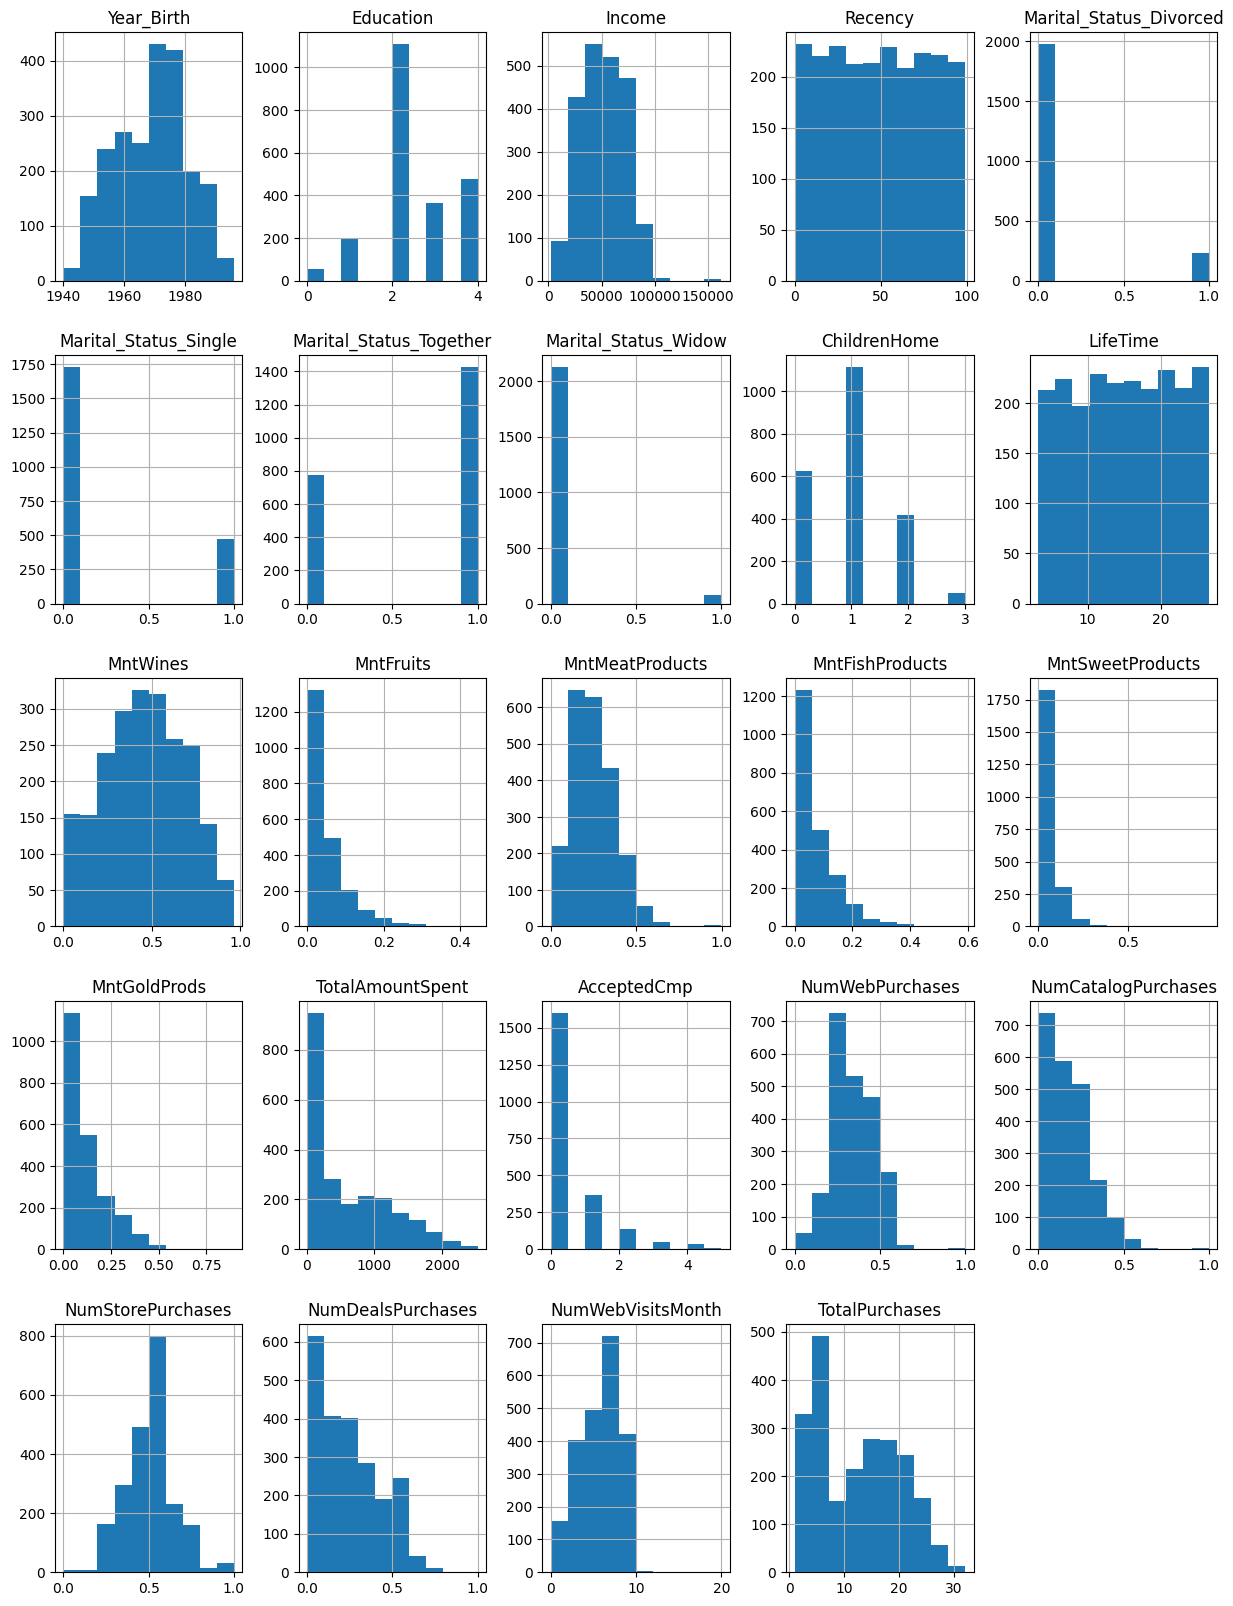

In [69]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_final.hist(ax=ax);

### Normalização

In [70]:
def scaler(df):
    df2 = df.copy()
    for column in df2:
        minimo = df2[column].min()
        maximo = df2[column].max()
        df2[column] = (df[column] - minimo) / (maximo - minimo)

    return df2

In [71]:
scaled_df = scaler(df_final)

In [72]:
scaled_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year_Birth,2203.0,0.516179,0.208790,0.0,0.339286,0.535714,0.660714,1.0
Education,2203.0,0.615070,0.251205,0.0,0.500000,0.500000,0.750000,1.0
Income,2203.0,0.309517,0.132629,0.0,0.205796,0.305883,0.412801,1.0
Recency,2203.0,0.494858,0.292626,0.0,0.242424,0.494949,0.747475,1.0
Marital_Status_Divorced,2203.0,0.103495,0.304674,0.0,0.000000,0.000000,0.000000,1.0
Marital_Status_Single,2203.0,0.214707,0.410712,0.0,0.000000,0.000000,0.000000,1.0
Marital_Status_Together,2203.0,0.647299,0.477919,0.0,0.000000,1.000000,1.000000,1.0
Marital_Status_Widow,2203.0,0.034498,0.182547,0.0,0.000000,0.000000,0.000000,1.0
ChildrenHome,2203.0,0.316689,0.249584,0.0,0.000000,0.333333,0.333333,1.0
LifeTime,2203.0,0.506590,0.289392,0.0,0.258941,0.509299,0.756795,1.0


### Método de Elbow

In [73]:
inertia = []
num_clusters = range(1,14)

for k in num_clusters:
    Model = KMeans(n_clusters=k)
    Model.fit(scaled_df)
    inertia.append(Model.inertia_)

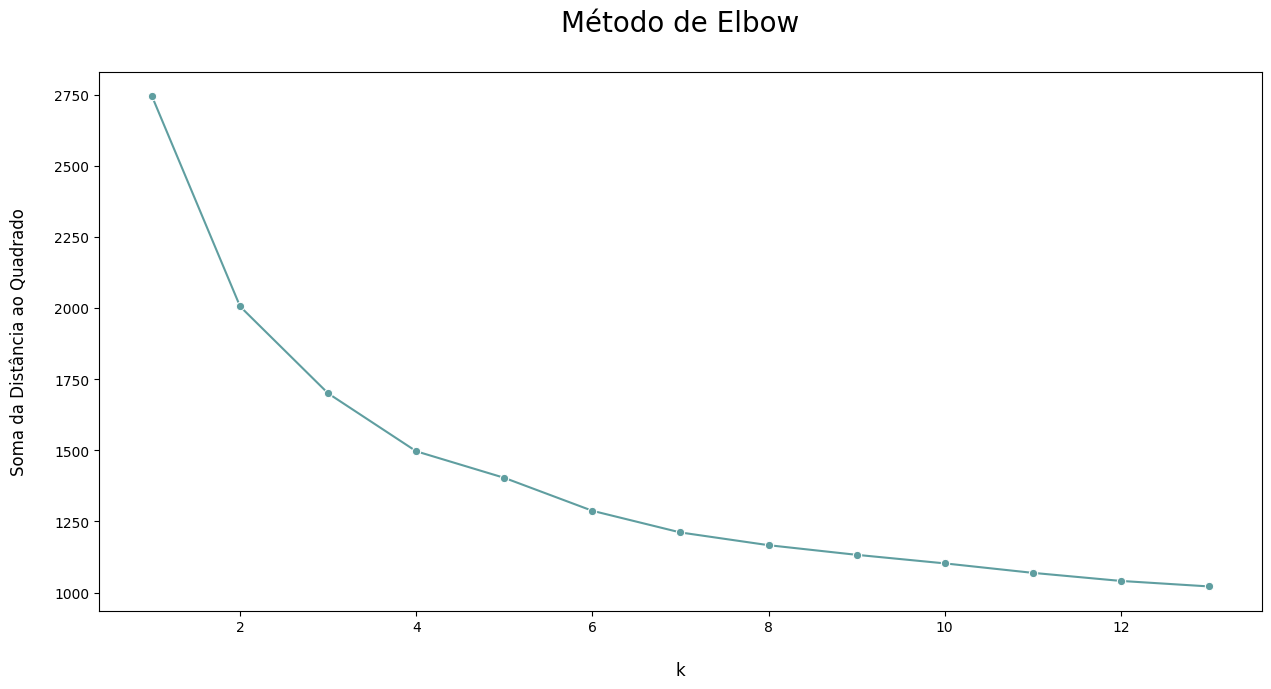

In [74]:
plt.figure(figsize=(15,7))
sns.lineplot(x=num_clusters, y=inertia, color='cadetblue', marker='o')
plt.xlabel('\nk', size=12)
plt.ylabel('Soma da Distância ao Quadrado\n', size=12)
plt.title('Método de Elbow\n', size=20)
plt.show()

### Alocação de Pesos

- A alocação é feita junta com o time de negocios

In [75]:
scaled_df.columns

Index(['Year_Birth', 'Education', 'Income', 'Recency',
       'Marital_Status_Divorced', 'Marital_Status_Single',
       'Marital_Status_Together', 'Marital_Status_Widow', 'ChildrenHome',
       'LifeTime', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'TotalAmountSpent', 'AcceptedCmp', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases',
       'NumWebVisitsMonth', 'TotalPurchases'],
      dtype='object')

In [76]:
scaled_df.TotalAmountSpent = 8*scaled_df.TotalAmountSpent
scaled_df.TotalPurchases = 6*scaled_df.TotalPurchases
scaled_df.Recency = 4*scaled_df.Recency
scaled_df.NumWebVisitsMonth = 4*scaled_df.NumWebVisitsMonth
scaled_df.Income = 4*scaled_df.Income
scaled_df.LifeTime = 4*scaled_df.LifeTime
scaled_df.Year_Birth = 2*scaled_df.Year_Birth
scaled_df.ChildrenHome = 2*scaled_df.ChildrenHome
scaled_df.Education = 2*scaled_df.Education

### KMeans

In [77]:
Model = KMeans(n_clusters=4)
clusters = Model.fit_predict(scaled_df)

In [78]:
df_final['Cluster'] = clusters

#### Salvando o Modelo

In [79]:
# save the model to disk
path = 'models/'
filename = 'modelo_finaliza.pkl'

pickle.dump(Model, open(path + filename, 'wb'))

In [80]:
# Load the model from disk
loaded_model = pickle.load(open(path + filename, 'rb'))

### Análise dos Clusters

In [81]:
df_final.Cluster.value_counts()

3    634
1    585
0    574
2    410
Name: Cluster, dtype: int64

In [90]:
customer_data = df_final.groupby('Cluster').mean().T
customer_data

Cluster,0,1,2,3
Year_Birth,1971.226481,1970.105983,1968.614634,1965.886435
Education,2.411150,2.302564,2.580488,2.572555
Income,36781.594077,36397.441026,77322.873171,63639.826498
Recency,22.914634,73.967521,50.597561,48.514196
Marital_Status_Divorced,0.097561,0.100855,0.102439,0.111987
Marital_Status_Single,0.226481,0.215385,0.253659,0.178233
Marital_Status_Together,0.646341,0.663248,0.609756,0.657729
Marital_Status_Widow,0.029617,0.020513,0.034146,0.052050
ChildrenHome,1.224739,1.270085,0.287805,0.834385
LifeTime,14.034669,14.506952,17.029350,15.260568


<AxesSubplot: xlabel='Cluster'>

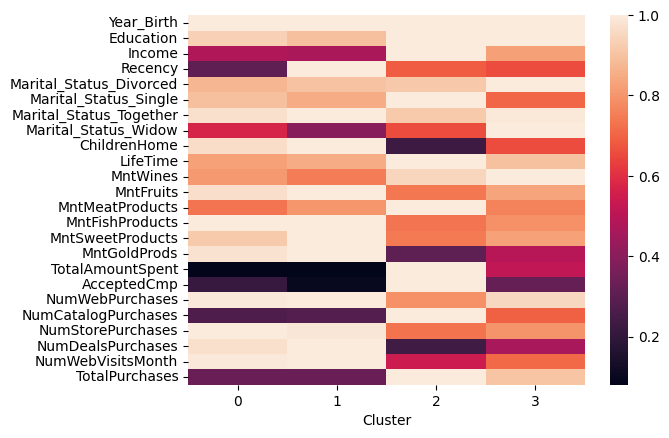

In [94]:
sns.heatmap((customer_data.div(customer_data.max(axis=1), axis=0)))

#### Cluster 0:
- Grupo com maior valor em renda
- Menor número de clientes
- Maior nível de educação
- São os que mais compram
- Ticket Médio mais alto
- Não costumam visitar tanto o website da empresa
- Não costumam comprar tanto em promoções
- Eles gostam de comprar nas lojas físicas e catálogos
- As categorias preferidas são a de carnes e vinhos
- A maioria não tem filhos em casa
- São em média os clientes cadastrados a mais tempo

#### Cluster 3:
- É o segundo grupo a fazer mais compras, porém com ticket médio inferior ( mas ainda assim trazem bastante receita para a empresa )
- Os clientes tem um salario anual relativamente alto
- São mais velhos
- Geralmente a maioria tem um filho em casa
- São os maiores consumidores de vinhos
- É o maior grupo

#### Cluster 2:
- É o Grupo mais jovem
- Menor poder aquisitivo
- Mais ativos dentro das empresas
- É o grupo que se cadastrou a menos tempo
- Gostam de fazer compras em promoções
- Gostam de fazer compras pelas lojas físicas
- Gostam de visitar o website para visualizar promoções ( hipotese )
- Gostam mais de gold prods que os outros clusters de maior valor

#### Cluster 1:
- É um grupo jovem
- Menor poder aquisitivo
- Baixa frequencia de compra ( menor ativo )
- A empresa precisa se atentar, pois tem uma alta frequencia em churn
- É o grupo que menos aceita promoções
- Tem maior números de filhos, sendo interessante aumentar o número de produtos destinados ao público infantil
- Grupo que mais faz compras em promoções (%).
- Gostam de fazer compras pelas lojas físicas
- Gostam mais de gold prods que os outros clusters de maior valor

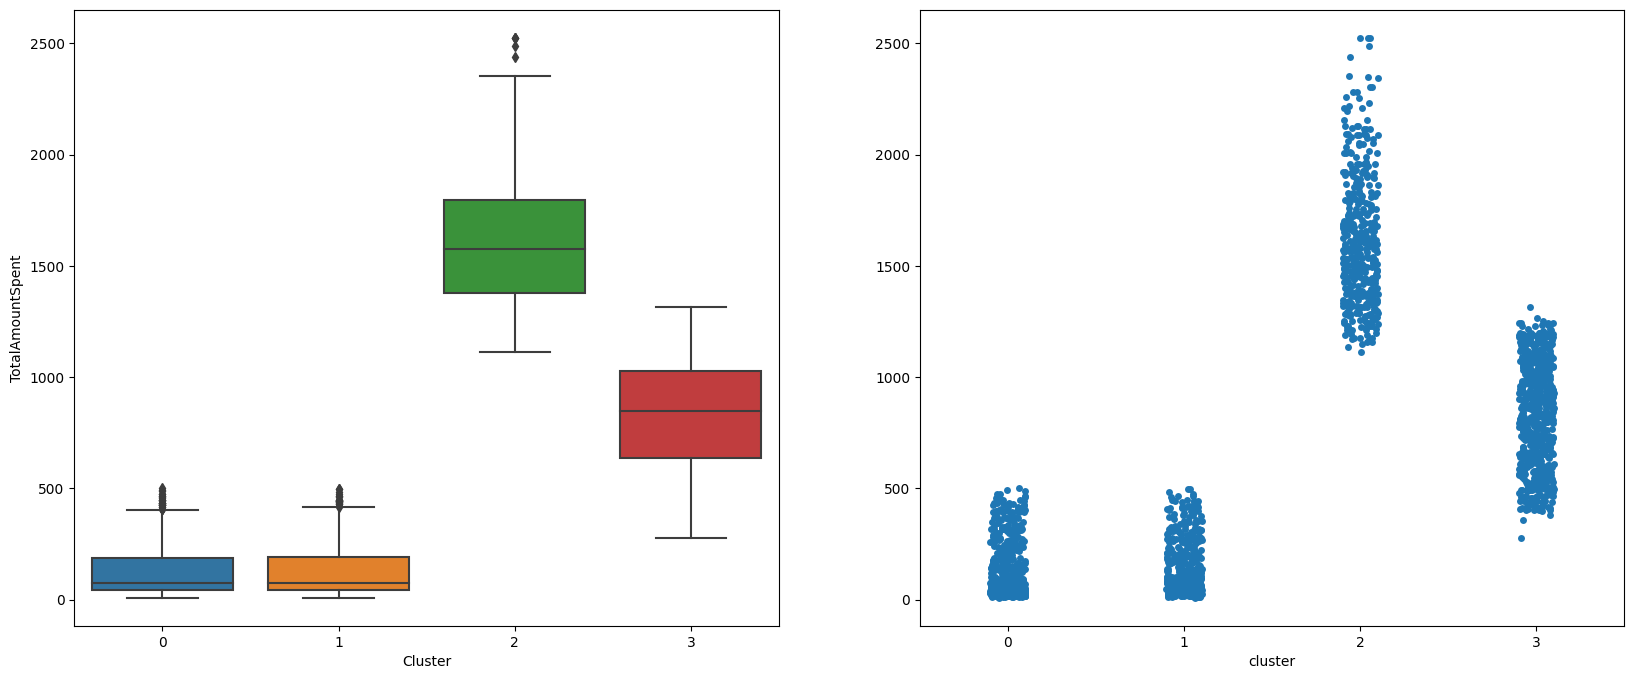

In [83]:
fig = plt.figure(figsize=(20,8))
gs = GridSpec(1,2)
sns.boxplot( x='Cluster', y='TotalAmountSpent', data=df_final, ax=fig.add_subplot(gs[0,0]))
plt.ylabel('TotalAmountSpent')
plt.xlabel('Cluster')
sns.stripplot( x='Cluster', y='TotalAmountSpent', data=df_final, ax=fig.add_subplot(gs[0,1]))
plt.ylabel(None)
plt.xlabel('cluster')
plt.show()

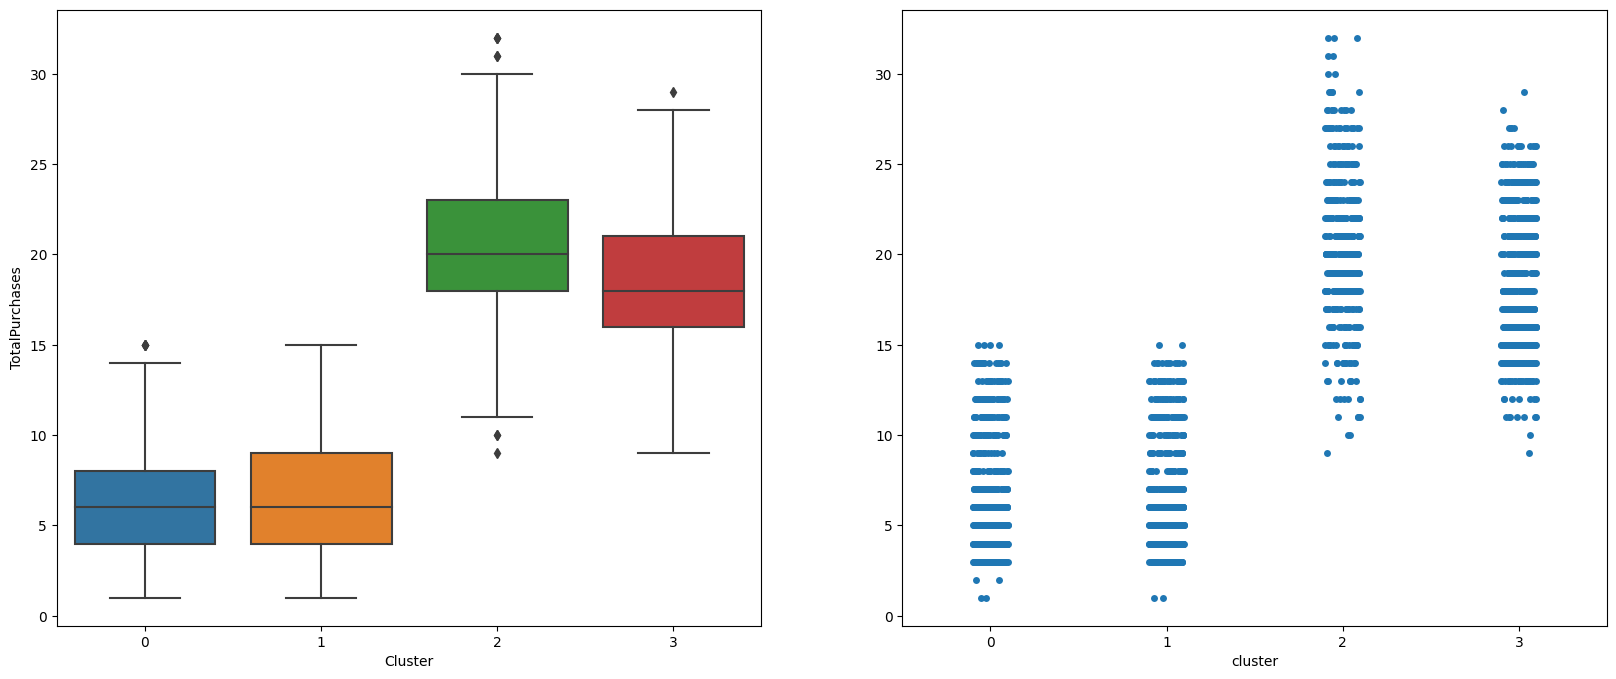

In [84]:
fig = plt.figure(figsize=(20,8))
gs = GridSpec(1,2)
sns.boxplot( x='Cluster', y='TotalPurchases', data=df_final, ax=fig.add_subplot(gs[0,0]))
plt.ylabel('TotalPurchases')
plt.xlabel('Cluster')
sns.stripplot( x='Cluster', y='TotalPurchases', data=df_final, ax=fig.add_subplot(gs[0,1]))
plt.ylabel(None)
plt.xlabel('cluster')
plt.show()

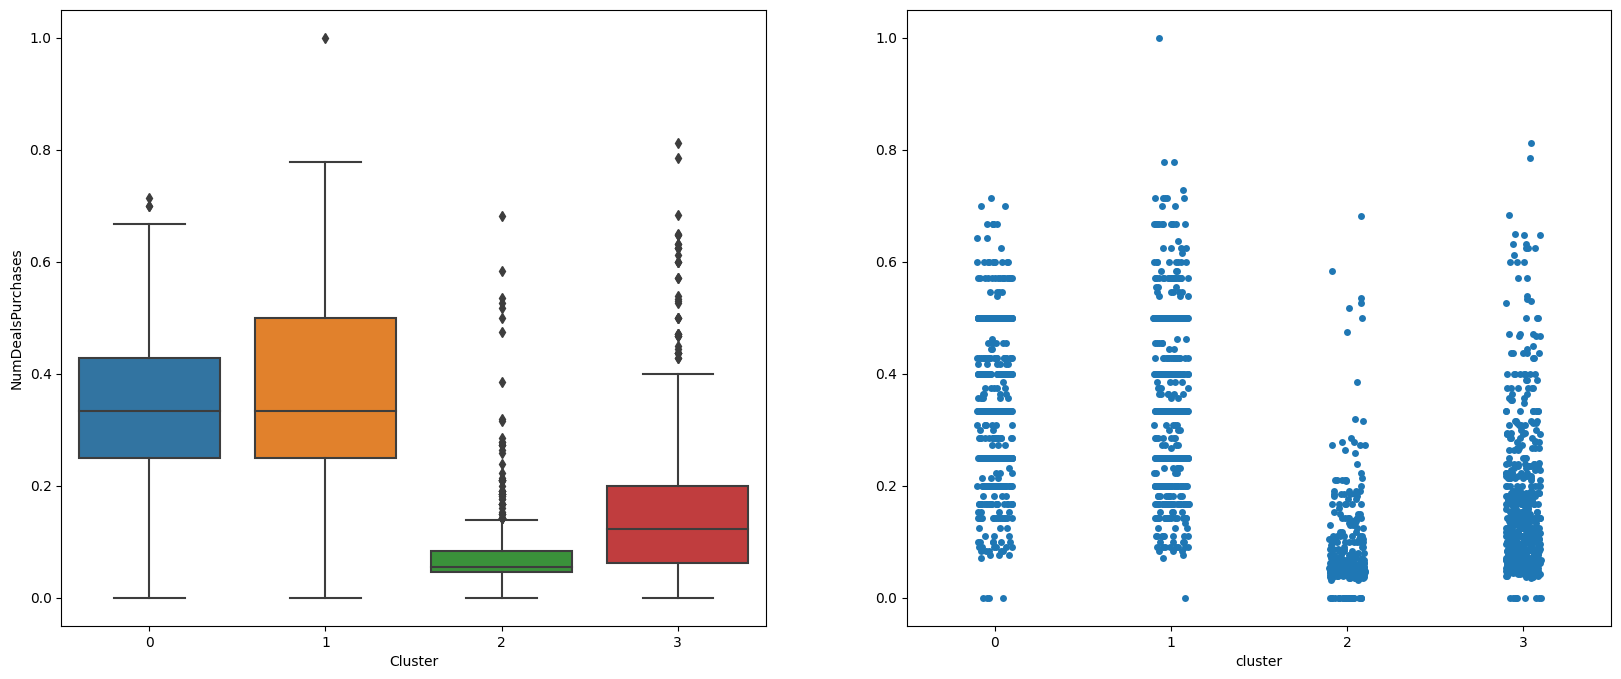

In [85]:
fig = plt.figure(figsize=(20,8))
gs = GridSpec(1,2)
sns.boxplot( x='Cluster', y='NumDealsPurchases', data=df_final, ax=fig.add_subplot(gs[0,0]))
plt.ylabel('NumDealsPurchases')
plt.xlabel('Cluster')
sns.stripplot( x='Cluster', y='NumDealsPurchases', data=df_final, ax=fig.add_subplot(gs[0,1]))
plt.ylabel(None)
plt.xlabel('cluster')
plt.show()

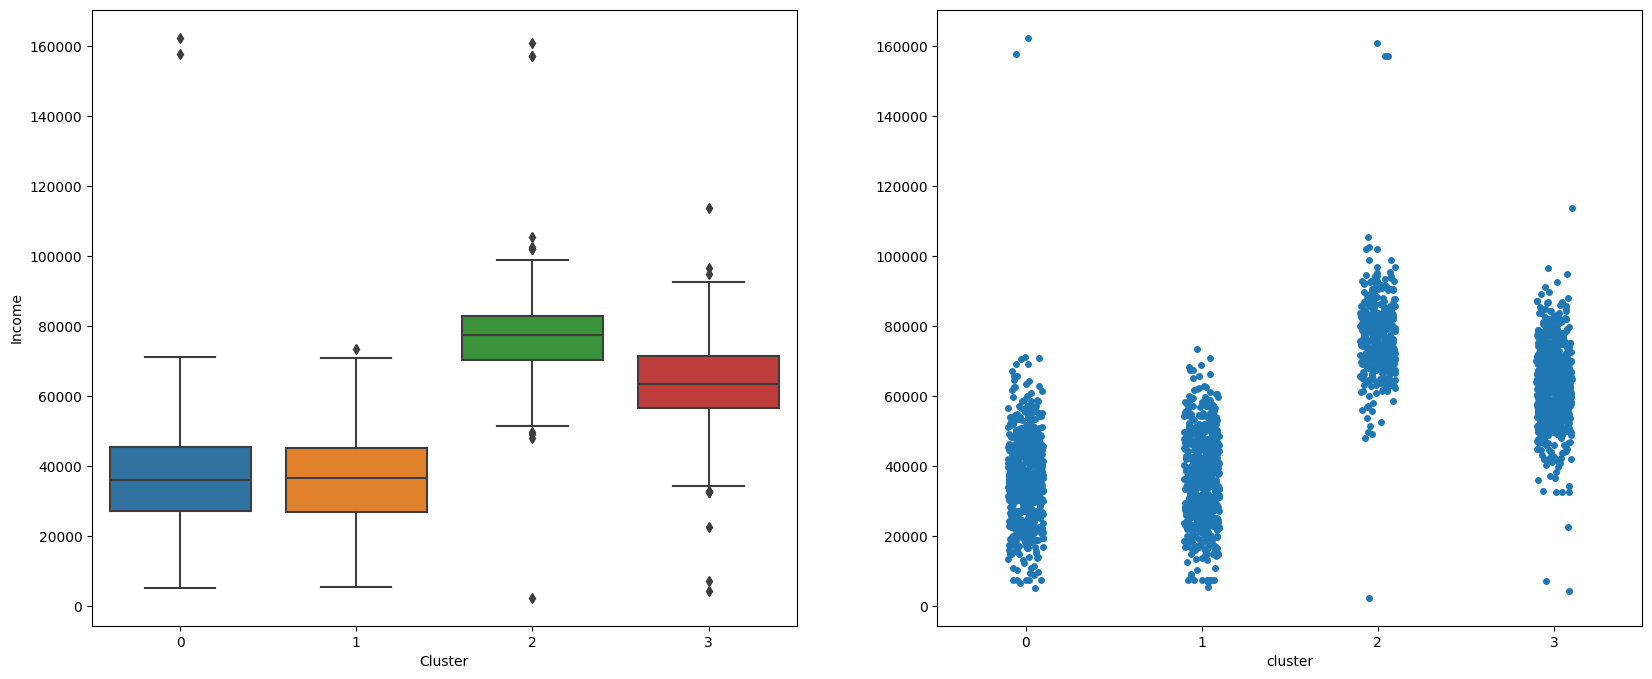

In [86]:
fig = plt.figure(figsize=(20,8))
gs = GridSpec(1,2)
sns.boxplot( x='Cluster', y='Income', data=df_final, ax=fig.add_subplot(gs[0,0]))
plt.ylabel('Income')
plt.xlabel('Cluster')
sns.stripplot( x='Cluster', y='Income', data=df_final, ax=fig.add_subplot(gs[0,1]))
plt.ylabel(None)
plt.xlabel('cluster')
plt.show()